# Introduction #

This is my feature engineering project for the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. This competition uses nearly the same data used in the exercises of the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course and is based on a [notebook](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices) by Ryan Holbrook from the course.

Various means of feature engineering will be explored in each section and compiled into a feature engineering pipeline at the end of this notebook.

# Step 1 - Preliminaries #
## Imports and Configuration ##

We'll start by importing the packages we used in the exercises and setting some notebook defaults. Unhide this cell if you'd like to see the libraries we'll use:

In [1]:

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

# Pandas display options
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy to get a fresh dataframe whenever needed. After applying the preprocessing steps as listed above, the data splits will be created: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that will be submitted to the competition for scoring on the leaderboard.

In [2]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

### Clean Data ###

Some of the categorical features in this dataset have what are apparently typos in their categories.

Referring to `data_description.txt`, the column `Exterior2nd` has 3 typos:
- `Brk Cmn` should be `BrkComm` 
- `Wd Sdng` should be `WdShing`
- `CmentBd` should be `CemntBd`

In [3]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
# df = pd.read_csv(data_dir / "train.csv", index_col="Id")

df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
# Merge the splits so we can process them together
df = pd.concat([df_train, df_test])

df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock', nan], dtype=object)

The column `BldgType` has 3 typos:
- `2fmCon` should be `2FmCon` 
- `Duplex` should be `Duplx`
- `Twnhs` should be `TwnhsI`

In [4]:
df.loc[:,'BldgType'].unique()

array(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], dtype=object)

There are some errors in `GarageYrBlt` where the year is > 2010. This data set only contains data up to 2010.

In [5]:
np.sort(df.loc[:,'GarageYrBlt'].unique())

array([1895., 1896., 1900., 1906., 1908., 1910., 1914., 1915., 1916.,
       1917., 1918., 1919., 1920., 1921., 1922., 1923., 1924., 1925.,
       1926., 1927., 1928., 1929., 1930., 1931., 1932., 1933., 1934.,
       1935., 1936., 1937., 1938., 1939., 1940., 1941., 1942., 1943.,
       1945., 1946., 1947., 1948., 1949., 1950., 1951., 1952., 1953.,
       1954., 1955., 1956., 1957., 1958., 1959., 1960., 1961., 1962.,
       1963., 1964., 1965., 1966., 1967., 1968., 1969., 1970., 1971.,
       1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980.,
       1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
       1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2207.,   nan])

**The clean() method below rectifies all the problems found:**

In [6]:
def clean(df):
    # typos in Exterior2nd
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm", 
                                                   "Wd Shng": "WdShing", 
                                                   "CmentBd": "CemntBd"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built. Data set was up to 2010 only.
    # where replaces values where the condition is FALSE
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,
    )
    return df


### Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. This cell defines the `encode` function:

In [7]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. "Missing value" indicators were tried too but didn't improve performance here: `1` whenever a value was imputed and `0` otherwise.

In [8]:
def impute(df):
    for name in df.select_dtypes("number"):
#         df[name + '_imputed'] = 0
#         df[name + '_imputed'].loc[df[name].isna()] = 1
#         df[name + '_imputed'].astype('category')
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
#         df[name + '_imputed'] = 0
#         df[name + '_imputed'].loc[df[name].isna()] = 1
#         df[name + '_imputed'].astype('category')
        df[name] = df[name].fillna("None")
    return df

# No difference in baseline score observed when I included the imputed feature.

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [9]:
df_train, df_test = load_data()

## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.

The `score_dataset()` function will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model, but another model to try could be a Linear Regression model such as Lasso or Ridge.


In [10]:
def score_dataset(X, y, model=XGBRegressor(), encoding="label"):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    if encoding == "label":
        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
    elif encoding == "onehot":
        for colname in X.select_dtypes(["category"]):
            X_encoded = pd.get_dummies(X[colname], prefix = colname, drop_first = True)
            X = X.join(X_encoded)
            X = X.drop(columns = colname)
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [11]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores #

We will use mutual information to compute a *utility score* for a feature, giving us an indication of how much potential the feature has. This hidden cell defines the two utility functions we used, `make_mi_scores` and `plot_mi_scores`: 

In [12]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.subplots(figsize=figsize)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    for idx, score in enumerate(scores):
        plt.annotate(f"{score:.4f}", (score, idx), color="black")
        

Let's look at our feature scores:

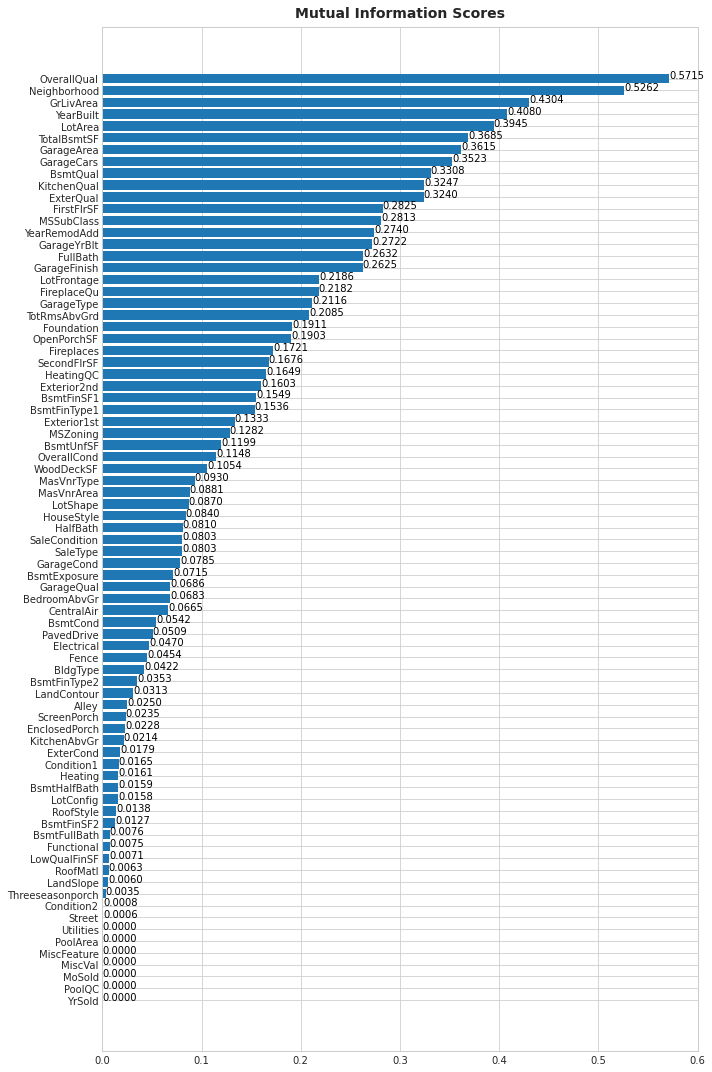

In [13]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores, figsize=(10,15))

We can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). The top scoring features will usually pay-off the most during feature development, so it is a good idea to focus efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

In [14]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

Removing them does lead to a modest performance gain:

In [15]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after dropping columns with 0 mi score: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after dropping columns with 0 mi score: 0.14338 RMSLE


# Step 3 - Create Features #

Now we'll start developing our feature set.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this:

```
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X
```

Let's go ahead and define one transformation now, a [label encoding](https://www.kaggle.com/alexisbcook/categorical-variables) for the categorical features:

In [16]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X


A label encoding is okay for any kind of categorical feature when you're using a tree-ensemble like XGBoost, even for unordered categories. If we wanted to try a linear regression model (also popular in this competition), we would instead want to use a one-hot encoding, especially for the features with unordered categories.

## Create Features with Pandas ##

Since we are working with XGBoost, a tree based model, we will focus on ratios and sums in creating features.

### Mathematical Transforms
**Test a feature of the ratio between GrLivArea and LotArea.**  
This ratio measures the efficiency of area usage. For housing, a house with a greater proportion of the Lot Area being built up should be worth more.

In [17]:
X = df_train.copy()
y = X.pop("SalePrice")
X["LivLotRatio"] = X.GrLivArea / X.LotArea

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after mathematical transforms: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after mathematical transforms: 0.14236 RMSLE


**Test a feature of average room size, representing spaciousness.**  
This ratio shows us how spacious the interior is.

In [18]:
X = df_train.copy()
y = X.pop("SalePrice")
X["Spaciousness"] = X.GrLivArea / X.TotRmsAbvGrd

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after mathematical transforms: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after mathematical transforms: 0.14079 RMSLE


**Test a feature of total outside square footage.**  
This ratio shows us the total size of usable exterior space.

In [19]:
X = df_train.copy()
y = X.pop("SalePrice")
X["TotalOutsideSF"] = \
        X.WoodDeckSF + X.OpenPorchSF + X.EnclosedPorch + \
        X.Threeseasonporch + X.ScreenPorch

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after mathematical transforms: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after mathematical transforms: 0.13938 RMSLE


4. **Test a feature of OverallQual * OverallCond.**  
    This ratio combines the information available in the quality and condition data fields. The price should be dependent on a combination of both factors and a high score in one can be worthless if the other is very low in value.

In [20]:
X = df_train.copy()
y = X.pop("SalePrice")
X["QualandCond"] = X.OverallQual.cat.codes * X.OverallCond.cat.codes

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after mathematical transforms: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after mathematical transforms: 0.13770 RMSLE


5. **Test a feature of the ratio of above ground area to basement area.**  
    Above ground living area should be more valued than basement area. Hence, a house with a larger proportion of above ground living area may be more desirable.

In [21]:
X = df_train.copy()
y = X.pop("SalePrice")
X['LivBsmtRatio'] = df.GrLivArea / (df.GrLivArea + df.TotalBsmtSF)

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after mathematical transforms: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after mathematical transforms: 0.14321 RMSLE


**All mathematical transforms:**

In [22]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = df.GrLivArea / df.TotRmsAbvGrd 
#     X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    X["TotalOutsideSF"] = \
        df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
        df.Threeseasonporch + df.ScreenPorch
    X["QualandCond"] = df.OverallQual.cat.codes * df.OverallCond.cat.codes
    X['LivBsmtRatio'] = df.GrLivArea / (df.GrLivArea + df.TotalBsmtSF)
    
#     This features ended up not helping performance
#     X["FrontageLotRatio"] = df.LotFrontage / df.LotArea
    return X

In [23]:
# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
X = X.join(mathematical_transforms(X))

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after mathematical transforms: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after mathematical transforms: 0.13764 RMSLE


### Interaction Features
Some features may seem unimportant on their own, but have strong interaction effects with another feature that can increase it's predictive power. Usually these can be identified by domain knowledge of the problem. For example, here we can identify categorical and numerical features that describe the same thing and study their interaction.

We will try `BsmtQual` and `TotalBsmtSF`.

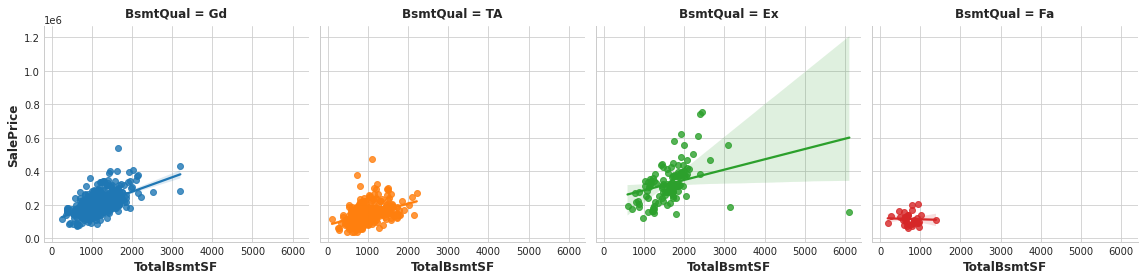

In [24]:
sns.lmplot(x = "TotalBsmtSF", y="SalePrice", hue="BsmtQual", col="BsmtQual", col_wrap=4, height=4, data = df)
plt.show()

In [25]:
def interactions(df):
    X = pd.get_dummies(df.BsmtQual, prefix="Bldg")
    X = X.mul(df.TotalBsmtSF, axis=0)
    return X

# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
X = X.join(interactions(X))

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding interaction features: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding interaction features: 0.14205 RMSLE


### Counts
The total number of outdoor areas available for a house should have an effect on the sale price:

In [26]:
def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X

# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
X = X.join(counts(X))

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding counts: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding counts: 0.14215 RMSLE


### Group Transforms
Group transforms aggregate information across multiple rows in a category. Here we will look at the median `GrLivArea` in each `Neighbourhood`.

In [27]:
def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
X = X.join(group_transforms(X))

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding group transforms: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding group transforms: 0.13902 RMSLE


Here are some ideas for other transforms we could explore:
- Square roots of area features. This would convert units of square feet to just feet.
- Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
- Other group statistics in `Neighboorhood`. We did the median of `GrLivArea`. Looking at `mean`, `std`, or `count` could be interesting. You could also try combining the group statistics with other features. Maybe the *difference* of `GrLivArea` and the median is important?

## k-Means Clustering ##

We can use the unsupervised algorithm, k-means clustering, to create new features. We can either use the cluster labels as a feature (a column with `0, 1, 2, ...`) or we can use the *distance* of the observations to each cluster. These features can sometimes be effective at untangling complicated spatial relationships.

We will look at a few features related to the area characteristics of the house.

In [28]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
X_cl = X.join(cluster_labels(X, cluster_features))
X_cd = X.join(cluster_distance(X, cluster_features))

score_cl = score_dataset(X_cl, y)
score_cd = score_dataset(X_cd, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding cluster labels: {score_cl:.5f} RMSLE")
print(f"Score after adding cluster distances: {score_cd:.5f} RMSLE")

Baseline score: 0.14351
Score after adding cluster labels: 0.14537 RMSLE
Score after adding cluster distances: 0.14781 RMSLE


## Principal Component Analysis ##

PCA is another unsupervised model we can use for feature creation. It can be used to decompose the variational structure in the data. The PCA algorithm gave us *loadings* which described each component of variation, and also the *components* which were the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are some utility functions for PCA:

In [29]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


Choosing a few highly correlated numeric features to sale price:

In [30]:
X = df_train.copy()
y = X.pop("SalePrice")

numerics = X.loc[:,[col for col in X if pd.api.types.is_numeric_dtype(X[col])]]
numerics.corrwith(y).sort_values(ascending=False)

GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
FirstFlrSF       0.605852
                   ...   
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Length: 33, dtype: float64

We obtain the principal components:

In [31]:
X = df_train.copy()
y = X.pop("SalePrice")
components = ["GrLivArea", "GarageArea", "TotalBsmtSF", "YearRemodAdd"]

pca, X_pca, loadings = apply_pca(X[components])
X_pca.index = X_pca.index + 1 #to match df_train index
loadings

,PC1,PC2,PC3,PC4
GrLivArea,0.511558,0.334709,-0.765680,0.200032
GarageArea,0.542671,0.055849,0.172729,-0.820094
TotalBsmtSF,0.518308,0.324224,0.617357,0.495082
YearRemodAdd,0.418537,-0.883023,-0.052628,0.205735


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

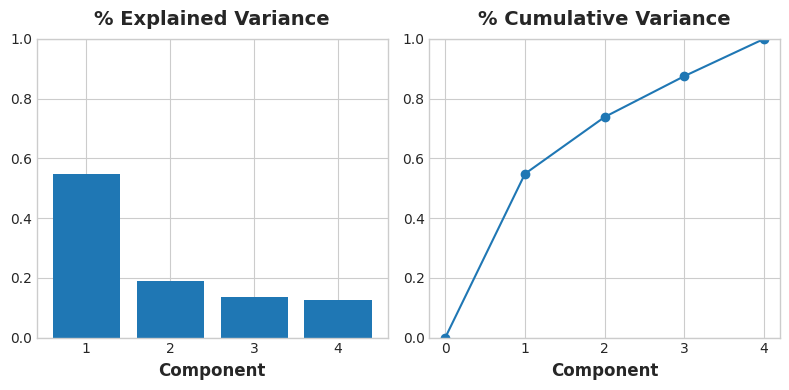

In [32]:
plot_variance(pca)

Examining the loadings table, see that PC1 gives roughly equal importance to the various features and indicates the importance of overall area and a house being recently remodelled or built. The explained variance for PC1 is also high. We can test out this feature by adding up the areas:

In [33]:
X = df_train.copy()
y = X.pop("SalePrice")
X["Feature1"] = X.GrLivArea + X.TotalBsmtSF + X.GarageArea

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding area feature: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding area feature: 0.14043 RMSLE


Are people more concerned about living space vs garage area? The next cell tells us that this may be the case.

In [34]:
X = df_train.copy()
y = X.pop("SalePrice")
X["Feature1"] = X.GrLivArea + X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding area feature: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding area feature: 0.13939 RMSLE


Looking at PC2, we see that sale price is positively correlated to `GrLivArea` and `TotalBsmtSF` but negatively correlated to `YearRemodAdd`. This tells us that larger houses and newer houses cost more. We can capture this using the feature below:

In [35]:
X = df_train.copy()
y = X.pop("SalePrice")
X["Feature1"] = (X.GrLivArea + X.TotalBsmtSF) * X.YearRemodAdd

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding area feature: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding area feature: 0.13472 RMSLE


Alternatively, we can simply add the PCA component to the dataframe instead of creating features. After testing, it was better to just add PC1 rather than the whole list of components

In [36]:
X = df_train.copy()
y = X.pop("SalePrice")
X = X.join(X_pca[["PC1"]])

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding principle component: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding principle component: 0.13538 RMSLE


**All PCA transforms**


In [37]:
def pca_inspired(df):
    X = pd.DataFrame()
#     X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = (df.GrLivArea + df.TotalBsmtSF) * df.YearRemodAdd
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    X_pca.index = X_pca.index + 1 #to match df_train index
    return X_pca[["PC1"]]


pca_features = ["GrLivArea", "GarageArea", "TotalBsmtSF", "YearRemodAdd"]

In [38]:
# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
X = X.join(pca_inspired(X))
# X = X.join(pca_components(X, pca_features))

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding pca inspired: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding pca inspired: 0.13472 RMSLE


These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, we could look at a correlation matrix for the dataset.

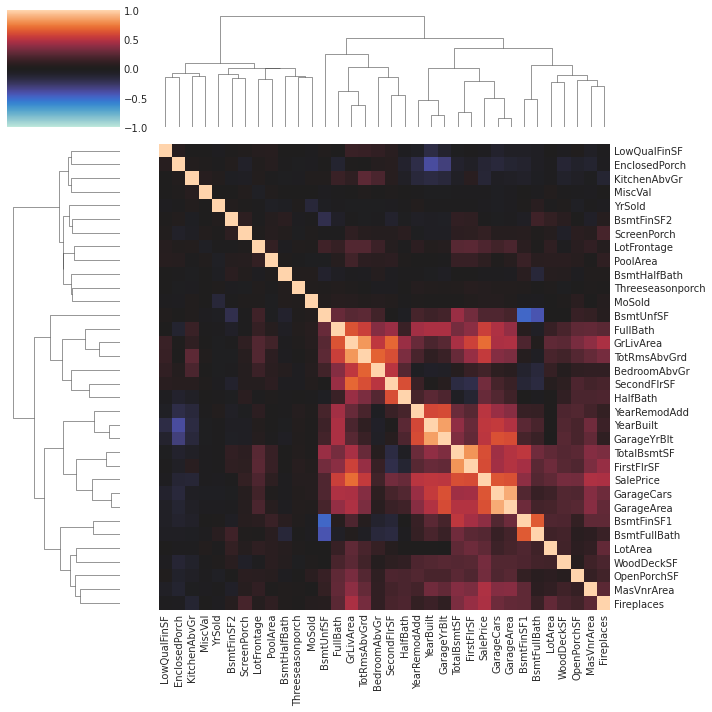

In [39]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

Groups of highly correlated features often yield interesting loadings.

### PCA Application - Indicate Outliers ###

PCA can also be used to determine houses that were **outliers**. Plotting the principal components and looking through the data sorted by PC values, we see that there are a group of houses in the `Edwards` neighborhood having a `SaleCondition` of `Partial` whose values were especially extreme.

The next transform will flag out these outliers for the model.

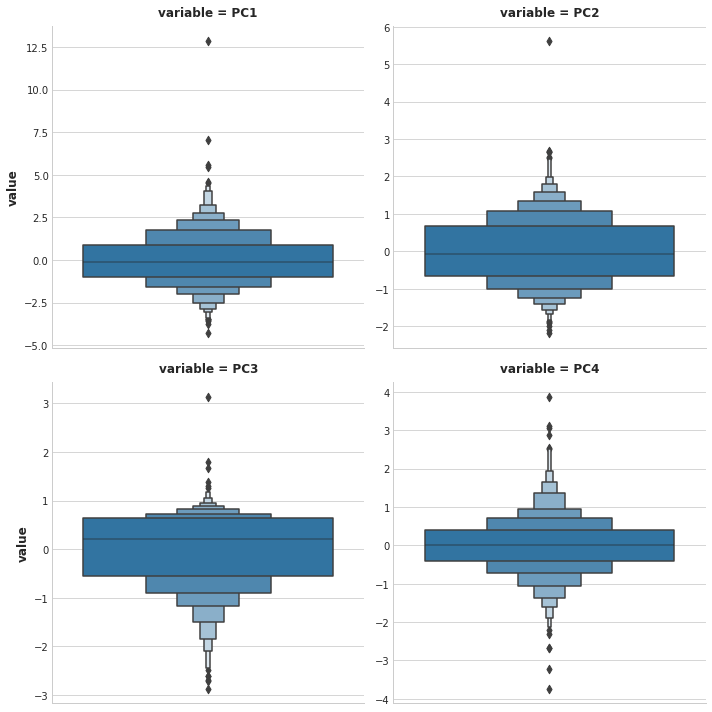

In [40]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [41]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1299,160000.0,Edwards,Partial,1418.0,2008,6110.0,5642
524,184750.0,Edwards,Partial,884.0,2008,3138.0,4676
1183,745000.0,NoRidge,Abnorml,813.0,1996,2396.0,4476
692,755000.0,NoRidge,Normal,832.0,1995,2444.0,4316
497,430000.0,NoRidge,Normal,546.0,1993,3200.0,3228
...,...,...,...,...,...,...,...
1180,93000.0,Edwards,Normal,0.0,1954,0.0,1124
637,60000.0,BrkSide,Normal,0.0,1950,264.0,800
706,55000.0,IDOTRR,Normal,0.0,1950,0.0,1092
1219,80500.0,BrkSide,Normal,0.0,1950,0.0,912


Looking through the data, it looks like sales in the `Neighborhood` Edwards and with `SaleCondition` Partial are the outliers.

In [42]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
X = X.join(indicate_outliers(X))

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after adding indicating outliers: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after adding indicating outliers: 0.14351 RMSLE


We can also consider applying some sort of robust scaler from scikit-learn's `sklearn.preprocessing` module to the outlying values, especially those in `GrLivArea`. [Here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) is a tutorial illustrating some of them. Another option could be to create a feature of "outlier scores" using one of scikit-learn's [outlier detectors](https://scikit-learn.org/stable/modules/outlier_detection.html).

## Target Encoding ##

A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target. For example, replacing neighborhoods with the average price of the houses in that neighborhood. Good candidates for target encoding have a large number of categories.

However, needing a separate holdout set to create a target encoding is rather wasteful of data. There is a way we can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:
1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next hidden cell is a wrapper we can use with any target encoder:

In [43]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


Use it like:

```
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
```

We can turn any of the encoders from the [`category_encoders`](http://contrib.scikit-learn.org/category_encoders/) library into a cross-fold encoder. The [`CatBoostEncoder`](http://contrib.scikit-learn.org/category_encoders/catboost.html) would be worth trying. It's similar to `MEstimateEncoder` but uses some tricks to better prevent overfitting. Its smoothing parameter is called `a` instead of `m`.

### Encoding
We list the categorical data types and find the ones with the most categories to be used when we create the final feature set at the end. Let's use Neighborhood and MSSubClass.

In [44]:
df_train.select_dtypes(["category"]).nunique().sort_values(ascending=False).head(10)

Neighborhood    25
Exterior2nd     16
Exterior1st     15
MSSubClass      15
OverallQual     10
OverallCond      9
SaleType         9
Condition1       9
Condition2       8
HouseStyle       8
dtype: int64

In [45]:
# Check effectiveness
X = df_train.copy()
y = X.pop("SalePrice")
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X = X.join(encoder.fit_transform(X, y, cols=["Neighborhood", "MSSubClass"]))

score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after target encoding: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after target encoding: 0.13929 RMSLE


## Create Final Feature Set ##

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones left uncommented worsened results in testing.

In [46]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))

    # Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))
    
    # Label Encode
    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

score = score_dataset(X_train, y_train)
print(f"Baseline score: {baseline_score:.5f}")
print(f"Score after all features: {score:.5f} RMSLE")

Baseline score: 0.14351
Score after all features: 0.13583 RMSLE


# Step 4 - Hyperparameter Tuning #

At this stage, we should do some hyperparameter tuning with XGBoost before creating the final submission.

In [47]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.12200873273962552

In [48]:
%%time
# Using RandomizedSearchCV to tune hyperparameters
parameters = dict(
    max_depth=np.arange(2,11),                      # maximum depth of each tree - try 2 to 10
    learning_rate=[0.0001,0.001,0.01,0.1],    # effect of each tree - try 0.0001 to 0.1
    n_estimators=np.arange(1,9)*1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=np.arange(1,11),    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=np.arange(2,11)*0.1,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=np.arange(2,11)*0.1,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=np.arange(0,11),         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=np.arange(0,11),        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=np.arange(1,5),   # set > 1 for boosted random forests
)

hptuner = RandomizedSearchCV(XGBRegressor(), parameters, scoring = "neg_mean_squared_error")

X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]
hptuner.fit(X_train, np.log(y_train))

CPU times: user 1h 41min 4s, sys: 32.3 s, total: 1h 41min 36s
Wall time: 26min 8s


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_ca...
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                            

In [49]:
xgb_params = hptuner.best_params_
print(xgb_params)

# hptuner_score = hptuner.score(X_train, np.log(y_train))
# print(np.sqrt(-1*hptuner_score))

xgb = XGBRegressor(**xgb_params)
print(score_dataset(X_train, y_train, xgb, encoding = None))

{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 2, 'num_parallel_tree': 4, 'n_estimators': 7000, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
0.12225215062365566


Just tuning these by hand can give you great results. However, you might like to try using one of scikit-learn's automatic [hyperparameter tuners](https://scikit-learn.org/stable/modules/grid_search.html). Or you could explore more advanced tuning libraries like [Optuna](https://optuna.readthedocs.io/en/stable/index.html) or [scikit-optimize](https://scikit-optimize.github.io/stable/).

Here is how you can use Optuna with XGBoost:

```
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params
```

Copy this into a code cell if you'd like to use it, but be aware that it will take quite a while to run. After it's done, you might enjoy using some of [Optuna's visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html).

# Step 5 - Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- create your feature set from the original data
- train XGBoost on the training data
- use the trained model to make predictions from the test set
- save the predictions to a CSV file

In [50]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y_train))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*